In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except ImportError:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    import os
    os.system('git clone https://github.com/pratik-kadlak/Pytorch')
    os.system('mv "Pytorch/6. Going Modular" "going_modular"')
    os.system('rm -rf Pytorch')
    from going_modular import data_setup, engine

In [2]:
# setting up device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"

# function for setting seeds
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.
    Args:
        seed (int, operational): Random seed to set. Default to 42.
    """
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)

In [3]:
# get data path

from pathlib import Path

data_path = Path("going_modular/data/")
image_path = data_path / "pizza_steak_sushi"

# setting directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('going_modular/data/pizza_steak_sushi/train'),
 PosixPath('going_modular/data/pizza_steak_sushi/test'))

In [4]:
# creating manual transfrom and dataloaders

# make transform
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform  = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

# creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1580c14d0>,
 ['pizza', 'steak', 'sushi'])

In [5]:
# creating auto tranforms and dataloaders

from torchvision import transforms

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

auto_transform = weights.transforms()

# creating dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transform,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1580d7910>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# getting the pretrained model
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
effnetb0 = torchvision.models.efficientnet_b0(weights=weights).to(device)

# froze all the layers
for param in effnetb0.features.parameters():
    param.requires_grad=False

# we have to update the last layer
from torch import nn

set_seeds(42)

effnetb0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

# print the summary of the model
from torchinfo import summary
summary(effnetb0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

## Training and Tracking Results

For tracking results we use __tensorboard -> https://pytorch.org/docs/stable/tensorboard.html__

In [7]:
# setting up loss_fn 
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.Adam(params=effnetb0.parameters())

In [8]:
# setting up a summary_writer
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [11]:
# for tracking the result we have to write the results to the file so we have to change the train() func

# there is no change in train_step and test_step so we can use them directly

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          device,
          epochs: int = 5):
    """
    Trains the given model using the specified data loaders, loss function, optimizer, and device.

    Args:
        model (nn.Module): The neural network model to train.
        train_dataloader (torch.utils.data.DataLoader): The DataLoader providing the training data.
        test_dataloader (torch.utils.data.DataLoader): The DataLoader providing the test data.
        loss_fn (nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use for updating model parameters.
        device (torch.device): The device to run the training on (e.g., 'cpu' or 'cuda').
        epochs (int, optional): The number of epochs to train the model (default is 5).

    Returns:
        dict: A dictionary containing the training and testing results including losses and accuracies.
    """
    
    # send the model to target device
    model = model.to(device)

    # creating a empty result dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = engine.train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = engine.test_step(model, test_dataloader, loss_fn, device)
        print(f"Epoch:{epoch}\tTrain_Loss:{train_loss:.4f}\tTrain_Acc:{train_acc:.4f}\tTest_Loss:{test_loss:.4f}\tTest_Acc:{test_acc:.4f}")

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # experiment tracking
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        
        writer.add_scalars(main_tag="Accuracy",
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc},
                           global_step=epoch)
        
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
        
        writer.close()

    return results

In [12]:
# training model
set_seeds()
results = train(model=effnetb0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

Epoch:0	Train_Loss:0.8121	Train_Acc:82.8125	Test_Loss:0.8163	Test_Acc:73.4848
Epoch:1	Train_Loss:0.8339	Train_Acc:71.0938	Test_Loss:0.7243	Test_Acc:85.6061
Epoch:2	Train_Loss:0.7002	Train_Acc:76.9531	Test_Loss:0.6269	Test_Acc:89.6780
Epoch:3	Train_Loss:0.6251	Train_Acc:86.3281	Test_Loss:0.6296	Test_Acc:85.6061
Epoch:4	Train_Loss:0.6659	Train_Acc:73.4375	Test_Loss:0.6489	Test_Acc:74.3371


## View Log Files with TensorBoard

In [13]:
# let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

## Function for tracking results
By default out `SummaryWriter()` class saves to `log_dir`. <br>
How about if we wanted to save different experiments to different folders?  <br>
In essence, one experiment = one folder  <br>
<br>
For example, we'd like to track:
* Experiment data/timestamp
* Experiment name
* Model Name
* Extra - is there anything else that should be tracked

In [14]:
def create_writer(experiment_name: str,
                  model_name: str, 
                  extra: str = None):
    import os
    from datetime import datetime
    
    # get current timestamp
    timestamp = datetime.now().strftime("%Y-%m-%d")
    
    # setting the log folder name 
    if extra: 
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter savign to {log_dir}")
    
    return SummaryWriter(log_dir=log_dir)

In [15]:
demo_writer = create_writer(experiment_name="data_10_percent",
                            model_name="effnetb0",
                            extra="epochs_5_optim_Adam")

demo_writer

[INFO] Created SummaryWriter savign to runs/2024-06-26/data_10_percent/effnetb0/epochs_5_optim_Adam


In [27]:
# updating train_func() more so that it can use create_writer() func and save the results in the folder

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          device,
          writer: torch.utils.tensorboard.writer.SummaryWriter,
          epochs: int = 5):
    """
    Trains the given model using the specified data loaders, loss function, optimizer, and device.

    Args:
        model (nn.Module): The neural network model to train.
        train_dataloader (torch.utils.data.DataLoader): The DataLoader providing the training data.
        test_dataloader (torch.utils.data.DataLoader): The DataLoader providing the test data.
        loss_fn (nn.Module): The loss function to use.
        optimizer (torch.optim.Optimizer): The optimizer to use for updating model parameters.
        device (torch.device): The device to run the training on (e.g., 'cpu' or 'cuda').
        log_dir (str): Directory to save the results of the experiment
        epochs (int, optional): The number of epochs to train the model (default is 5).

    Returns:
        dict: A dictionary containing the training and testing results including losses and accuracies.
    """
    
    # send the model to target device
    model = model.to(device)

    # creating a empty result dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in range(epochs):
        train_loss, train_acc = engine.train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = engine.test_step(model, test_dataloader, loss_fn, device)
        print(f"Epoch:{epoch}\tTrain_Loss:{train_loss:.4f}\tTrain_Acc:{train_acc:.4f}\tTest_Loss:{test_loss:.4f}\tTest_Acc:{test_acc:.4f}")

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
        # experiment tracking
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)

            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc},
                               global_step=epoch)

            writer.add_graph(model=model,
                             input_to_model=torch.randn(32, 3, 224, 224).to(device))

            writer.close()
        else:
            pass

    return results

## Running Various Experiments

For Running the experiments we will need 2 datasets
1. pizza, steak, sushi - 10% -> https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
2. pizza, steak, sushi - 20% -> https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip

In [17]:
import os
import requests
import zipfile

def download_data(source: str, destination: str):
    """
    Downloads a zip file from the specified source URL and extracts it to the specified destination directory.

    Parameters:
    source (str): URL of the zip file to be downloaded.
    destination (str): Directory where the zip file should be extracted.
    """
    # Check if the destination directory already exists
    if not os.path.exists(destination):
        os.makedirs(destination)

    # Download the file
    print(f"[INFO] Downloading data from {source}...")
    response = requests.get(source)
    zip_path = os.path.join(destination, "data.zip")

    # Save the zip file
    with open(zip_path, "wb") as f:
        f.write(response.content)
    
    # Extract the zip file
    print(f"[INFO] Extracting data to {destination}...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(destination)
    
    # Remove the zip file after extraction
    os.remove(zip_path)
    print(f"[INFO] Data downloaded and extracted to {destination}.")
    


# downloading both datasets
download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
              destination="pizza_steak_sushi")

download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
              destination="pizza_steak_sushi_20_percent")

[INFO] Downloading data from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Extracting data to pizza_steak_sushi...
[INFO] Data downloaded and extracted to pizza_steak_sushi.
[INFO] Downloading data from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Extracting data to pizza_steak_sushi_20_percent...
[INFO] Data downloaded and extracted to pizza_steak_sushi_20_percent.


__Transorming Datasets and creating DataLoaders__

In [18]:
# get data path

from pathlib import Path

data_10_percent_path = Path("pizza_steak_sushi/")
data_20_percent_path = Path("pizza_steak_sushi_20_percent/")

# data_path = Path("going_modular/data/")

# training dataset paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# we will have only one test dataset so that the comparison can be fair
test_dir_10_percent = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir_10_percent 

(PosixPath('pizza_steak_sushi/train'),
 PosixPath('pizza_steak_sushi_20_percent/train'),
 PosixPath('pizza_steak_sushi/test'))

In [19]:
# create transform
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform  = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    normalize
])

# creating dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                                          test_dir=test_dir_10_percent,
                                                                                          transform=manual_transform,
                                                                                          batch_size=32)

train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                          test_dir=test_dir_10_percent,
                                                                                          transform=manual_transform,
                                                                                          batch_size=32)

print(f"train_dataloader_10_percent num_batches: {len(train_dataloader_10_percent)}")
print(f"train_dataloader_20_percent num_batches: {len(train_dataloader_20_percent)}")
print(f"test_dataloader num_batches: {len(test_dataloader)}")

train_dataloader_10_percent num_batches: 8
train_dataloader_20_percent num_batches: 15
test_dataloader num_batches: 3


In [20]:
# create an effnetb0 feature extractor
def create_effnetb0():
    # loading the model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # freeze all the layers
    for param in model.features.parameters():
        param.requires_grad=False
    
    set_seeds()
    
    # creating last layer compatible
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280,
                  out_features=len(class_names))
    ).to(device)
    
    # giving model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [21]:
def create_effnetb2():
    # loading the model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)
    
    # freeze all the layers
    for params in model.features.parameters():
        params.requires_grad=False
        
    # set random seeds
    set_seeds()
    
    # creating last layers compatible
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                  out_features=len(class_names))
    ).to(device)
    
    # giving model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model...")
    return model

In [22]:
effnetb0 = create_effnetb0()
summary(effnetb0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

[INFO] Created new effnetb0 model...


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1280, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [23]:
effnetb2 = create_effnetb2()
summary(effnetb2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

[INFO] Created new effnetb2 model...


Layer (type (var_name))                                      Input Shape               Output Shape              Param #                   Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]         [32, 3]                   --                        Partial
├─Sequential (features)                                      [32, 3, 224, 224]         [32, 1408, 7, 7]          --                        False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]         [32, 32, 112, 112]        --                        False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]         [32, 32, 112, 112]        (864)                     False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]        [32, 32, 112, 112]        (64)                      False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]        [32, 32, 112, 112]        --         

In [24]:
# create epoch lists
num_epochs = [5, 10]

# model's list
models = ["effnetb0", "effnetb2"]

# create a dictionary of dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [28]:
# since we will have to save the different models and then choose the best among them
from going_modular.utils import save_model

# set the seeds
set_seeds()

# to track experment number
experiment_number = 0

# looping through dataloaders
for dataloader_name, train_dataloader in train_dataloaders.items():
    # loop through the number of epochs
    for epoch in num_epochs:
        # loop through the differnet models
        for model_name in models:
            # print some info
            experiment_number += 1
            print(f"exp:{experiment_number}\tmodel:{model_name}\tdataloder:{dataloader_name}\tepochs:{epoch}")
            
            # create model 
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
                
            # creating loss_fn and optimizers ans writer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            writer = create_writer(experiment_name=dataloader_name,
                                   model_name=model_name,
                                   extra=f"epochs_{epoch}_optim_Adam")
            
            # train the model
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  epochs=epoch,
                  device=device,
                  writer=writer)
            
            # save the model to file so that we can import it later
            save_filepath = f"model_{model_name}_dataloader_{dataloader_name}_epochs_{epoch}.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            

exp:1	model:effnetb0	dataloder:data_10_percent	epochs:5
[INFO] Created new effnetb0 model...
[INFO] Created SummaryWriter savign to runs/2024-06-26/data_10_percent/effnetb0/epochs_5_optim_Adam
Epoch:0	Train_Loss:1.0627	Train_Acc:46.0938	Test_Loss:0.9336	Test_Acc:45.7386
Epoch:1	Train_Loss:0.9386	Train_Acc:57.8125	Test_Loss:0.8284	Test_Acc:61.0795
Epoch:2	Train_Loss:0.8021	Train_Acc:69.9219	Test_Loss:0.7198	Test_Acc:83.5227
Epoch:3	Train_Loss:0.7139	Train_Acc:76.9531	Test_Loss:0.6196	Test_Acc:89.6780
Epoch:4	Train_Loss:0.6100	Train_Acc:89.0625	Test_Loss:0.5765	Test_Acc:89.6780
[INFO] Saving model to: models/model_effnetb0_dataloader_data_10_percent_epochs_5.pth
exp:2	model:effnetb2	dataloder:data_10_percent	epochs:5
[INFO] Created new effnetb2 model...
[INFO] Created SummaryWriter savign to runs/2024-06-26/data_10_percent/effnetb2/epochs_5_optim_Adam
Epoch:0	Train_Loss:1.0828	Train_Acc:35.5469	Test_Loss:0.9398	Test_Acc:72.1591
Epoch:1	Train_Loss:0.8891	Train_Acc:74.6094	Test_Loss:0.8893

__View the results__

In [29]:
# let's view our experiments from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1021), started 0:32:45 ago. (Use '!kill 1021' to kill it.)

## Loading the best model and making predictions
Our Best Model is : __models/model_effnetb2_dataloader_data_20_percent_epochs_5__

In [33]:
best_model_path = "models/model_effnetb2_dataloader_data_20_percent_epochs_5.pth"

# instantiate a nwe instance of effnetb2
best_model = create_effnetb2()

# load the saved dict 
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model...


<All keys matched successfully>

In [36]:
# checking the size of the model
from pathlib import Path
effnetb2_size = Path(best_model_path).stat().st_size / (1024*1024)
print(f"Effnetb2_Model_size: {effnetb2_size:.4f} MB")

Effnetb2_Model_size: 29.8430 MB


In [38]:
from typing import List, Tuple
from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        img_dir: str,
                        class_names: List[str],
                        img_size: Tuple[int, int] = (224, 224), 
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
    # open image with PIL
    img = Image.open(img_dir)
    
    # create a transform is one doesn't exist
    if transform == None:
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
    
    # transform the image and unsqueeze for extra batch dimension
    transformed_img = transform(img).unsqueeze(dim=0)  
        
    # putting model to the correct device
    model = model.to(device)
    transformed_img = transformed_img.to(device)
    
    # prediction
    model.eval()
    with torch.inference_mode():
        y_logits = model(transformed_img)
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        
    # plot the image
    plt.figure()
    plt.imshow(img)
    plt.axis(False)
    plt.title(f"Pred: {class_names[y_pred]}")

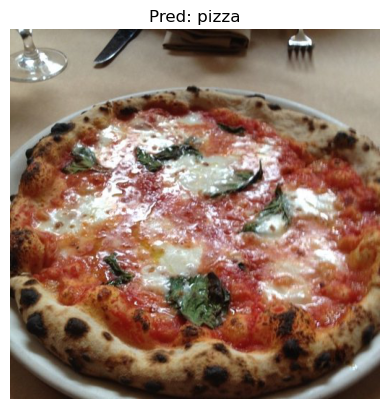

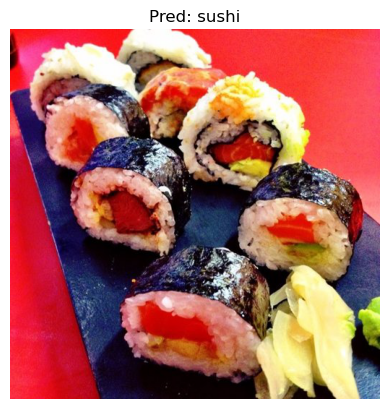

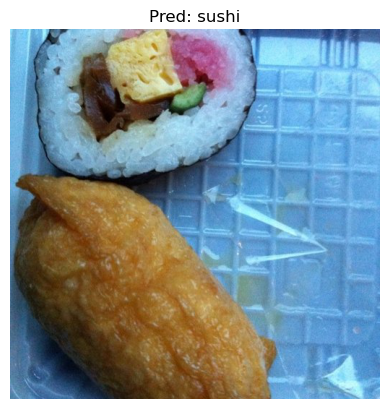

In [44]:
import random
num_images = 3
test_img_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_images_sample = random.sample(population=test_img_path_list,
                                   k = num_images)

for img_dir in test_images_sample:
    pred_and_plot_image(model=model,
                        img_dir=img_dir,
                        class_names=class_names,
                        img_size=(224, 224), 
                        transform=None,
                        device=device)